# *Portfolio Optimization Project Using Modern Portfolio Theory (MPT) and Markowitz Model

Goal: Constructing a moderately aggressive, risk-aware portfolio for a long-term investor seeking stable returns with exposure to growth.

Importing Required liabraries 

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize


# Section 1: Defining Tickers and Time Range 

In [12]:
#Defining the list of tickers for my choosen asstes (EFTs+Stocks)
tickers = ["SPY", "AGG", "EFA", "MSFT", "JPM", "NVDA", "JNJ", "PG"]

In [13]:
#Setting the end date to today
end_date = datetime.today()

In [14]:
#Setting the start date to 5 years ago
start_date= end_date - timedelta(days = 5*365)
print(start_date)

2020-08-02 21:12:23.000864


# Section 2: Downloading adjusted close price 

In [15]:
#Downnloading close price for all tickers at once
adj_close_df = pd.DataFrame()

In [16]:
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date,  auto_adjust=False)
    adj_close_df[ticker]=data["Adj Close"]

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AGG']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['EFA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JPM']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: YFRateLimitError('Too Many Requests. Rate limited.

In [10]:
#displaying data frame
print(adj_close_df)

Empty DataFrame
Columns: [SPY, AGG, EFA, MSFT, JPM, NVDA, JNJ, PG]
Index: []


# Section 3: Calculating Lognormal Returns

In [122]:
#Calculating lognormal returns for each ticker 

price_ratio = adj_close_df / adj_close_df.shift(1)  
log_return = np.log(price_ratio)

Dropping any Mssing Values 

In [32]:
log_return=log_return.dropna()

# Section 4 : Calculate Covariance Matrix 

In [34]:
# Calculating covariance 
cov_matrix = log_return.cov()*252
print(cov_matrix)

           SPY       AGG       EFA      MSFT       JPM      NVDA       JNJ  \
SPY   0.031085  0.002016  0.023455  0.036540  0.027665  0.064893  0.008079   
AGG   0.002016  0.003615  0.002258  0.002577 -0.001006  0.004078  0.001260   
EFA   0.023455  0.002258  0.027296  0.024336  0.024032  0.045008  0.007390   
MSFT  0.036540  0.002577  0.024336  0.072565  0.019648  0.091760  0.005714   
JPM   0.027665 -0.001006  0.024032  0.019648  0.066847  0.037041  0.010289   
NVDA  0.064893  0.004078  0.045008  0.091760  0.037041  0.276552 -0.005139   
JNJ   0.008079  0.001260  0.007390  0.005714  0.010289 -0.005139  0.027950   
PG    0.010942  0.001844  0.009091  0.011864  0.008174  0.006228  0.013365   

            PG  
SPY   0.010942  
AGG   0.001844  
EFA   0.009091  
MSFT  0.011864  
JPM   0.008174  
NVDA  0.006228  
JNJ   0.013365  
PG    0.029686  


Confirming log vs. simple return differences are negligible (<0.01%)

In [50]:
# Validating Return Type Assumptions

log_means = log_return.mean()
simple_means = adj_close_df.pct_change().mean()

# Comparing differences
difference = (np.exp(log_means + 0.5*log_return.var()) - 1) - simple_means
print("Difference (%):\n", difference * 100)  # Convert to percentage

if (abs(difference) > 0.0001).any():  # If any difference > 0.01%
    print("[WARNING] Large return-type differences detected for:", 
          difference[difference > 0.0001].index.tolist())
else:
    print("Validation passed: return-type differences < 0.01%")


Difference (%):
 SPY     3.227226e-06
AGG     5.126124e-07
EFA     3.040464e-06
MSFT    9.928127e-06
JPM    -1.913598e-05
NVDA   -8.801125e-05
JNJ     8.956586e-06
PG      1.765311e-05
dtype: float64
Validation passed: return-type differences < 0.01%


# Section 5: Defining Portfolio Performance Metrics 

In [51]:
#calculating the portfolio standard deviation

def standard_deviation (weights, cov_matrix):
    """Annualized portfolio volatility (standard deviation)."""
    variance = weights.T @cov_matrix @weights
    return np.sqrt(variance)

In [52]:
#calculating the expected portfolio return
def expected_return (weights, log_return):
    """Annualized expected portfolio return."""
    return np.sum(log_return.mean()*weights)*252

In [54]:
# calculating sharpe ratio 

def sharpe_ratio(weights, log_return, cov_matrix, risk_free_rate):
    """Risk-adjusted return metric (higher = better)."""
    er = expected_return(weights, log_return)
    sd = standard_deviation(weights, cov_matrix)
    return (er - risk_free_rate) / sd

In [55]:
test_weights = np.array([1/len(tickers)] * len(tickers))
print(f"Test Sharpe Ratio: {sharpe_ratio(test_weights, log_return, cov_matrix, risk_free_rate):.2f}")

Test Sharpe Ratio: 0.80


# Section 6: Portfolio Optimization 

Setting the risk- free rate 

In [ ]:
# Get current 10-year Treasury yield (risk-free proxy)
treasury = yf.Ticker("^TNX") #fetching 10 year US treasury yeild
risk_free_rate = treasury.history(period="1d")['Close'].iloc[-1]/100  # Convert % to decimal
print(f"Risk-Free Rate: {risk_free_rate}")

Risk-Free Rate: 0.04452000141143799


In [56]:
# Defining the function to mimimize (negative sharpe ratio)
def negative_sharpe_ratio(weights, log_return, cov_matrix, risk_free_rate):
    """Negative Sharpe ratio for minimization"""
    return -sharpe_ratio(weights, log_return, cov_matrix, risk_free_rate)

In [113]:
#Setting the constarint bounds for optimization

# RULE 1: Weights must sum to 100% (no leftover cash)

constraints = [ # Sum of weights = 100% (fully invested)
               {'type':'eq','fun': lambda weights: np.sum(weights)-1},

               # Tech sector (NVDA + MSFT) < 30% of portfolio
               {'type': 'ineq', 'fun': lambda weights: 0.3 - (weights[tickers.index("NVDA")] + weights[tickers.index("MSFT")])}
]


# Bounds: No asset <5% or >20% (diversification rule)
bounds = [(0.05, 0.20) for _ in range(len(tickers))]


In [114]:
#setting initial weights 

initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


In [116]:

print("Individual weights:", initial_weights)  # Should show [0.125, 0.125, ...] for 8 tickers
print("Sum of weights:", np.sum(initial_weights))  # Must be 1.0

Individual weights: [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
Sum of weights: 1.0


Comparing to Benchmarks 

In [117]:
#Calculating equal-weighted performance for comparison

equal_weights = np.array([1/len(tickers)]*len(tickers))
equal_return = expected_return(equal_weights, log_return)
equal_vol = standard_deviation(equal_weights, cov_matrix)
equal_sharpe = sharpe_ratio(equal_weights, log_return, cov_matrix, risk_free_rate)

In [118]:
#Optimize the weight to maximise Sharpe Ratio
optimized_results=minimize(negative_sharpe_ratio,initial_weights, args= (log_return,cov_matrix,risk_free_rate),method='SLSQP',constraints=constraints,bounds=bounds)

In [119]:
#Getting Optimial weights 
optimal_weights = optimized_results.x

# Section 7: Analyze the optimal Portfolio 

In [120]:
# Print optimal weights
print('optimal_weights:')
for ticker,weight in zip(tickers,optimal_weights):
    print(f'{ticker}:{weight: .2%}')

print()
optimal_portfolio_return= expected_return(optimal_weights,log_return)
optimal_portfolio_volatility= standard_deviation(optimal_weights,cov_matrix)
optimal_sharpe_ratio= sharpe_ratio(optimal_weights,log_return,cov_matrix,risk_free_rate)

print(f"Expected Annual Return : {optimal_portfolio_return: .4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility: .4f}")
print(f"Sharpe Ratio : {optimal_sharpe_ratio: .4f}")

optimal_weights:
SPY: 6.03%
AGG: 5.00%
EFA: 5.00%
MSFT: 10.00%
JPM: 20.00%
NVDA: 20.00%
JNJ: 13.97%
PG: 20.00%

Expected Annual Return :  0.2122
Expected Volatility:  0.1786
Sharpe Ratio :  0.9389


# Section 7:  Visualization 

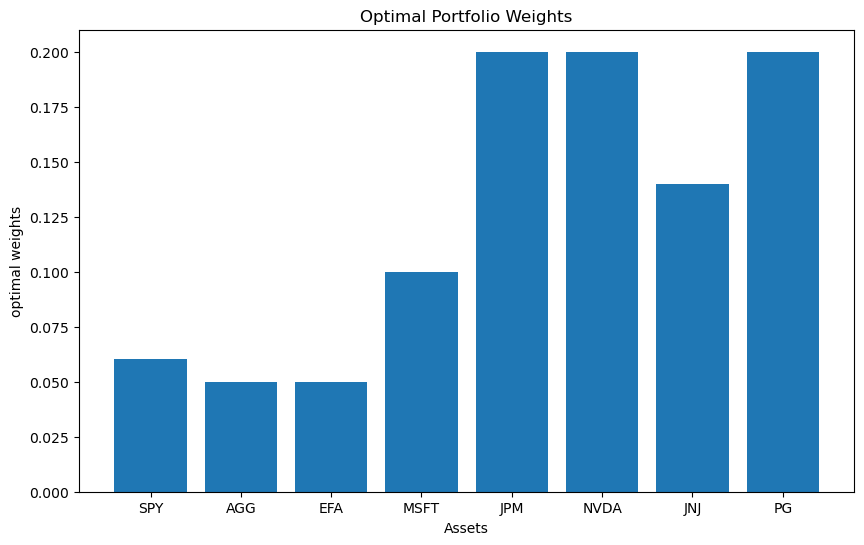

In [121]:
#Displaying the final portfolio graphically 


#importing required liabrary
import matplotlib.pyplot as plt 

#creating a vbar chart of optimal weights 
plt.figure(figsize=(10,6))
plt.bar(tickers,optimal_weights)

#Add labels and a title 
plt.xlabel('Assets')
plt.ylabel('optimal weights')
plt.title("Optimal Portfolio Weights")

#Display 
plt.show()

 
